In [1]:
import numpy as np
import h5py

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
from keras.layers import Input, Flatten, Dense, Dropout,  Activation, Conv3D, MaxPooling3D, UpSampling3D, BatchNormalization, Activation, Reshape
from keras.layers import Conv2D, MaxPooling2D
#from keras.utils import multi_gpu_model

from keras.optimizers import SGD
from keras.layers.merge import concatenate, add

#from keras.utils.io_utils import HDF5Matrix
from keras.utils import plot_model
from keras import optimizers

import os
import numpy as np
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from random import shuffle

In [2]:
def conv3d_block(input_tensor, filters, kernel_size, activation_fun = "linear"):
    # first layer
    x = Conv3D(filters=filters, kernel_size=kernel_size, kernel_initializer="he_normal", padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation(activation_fun)(x)

    return x

kernel_size = (5,5,5)
act_fun = "relu"

############### DEFINE SET OF INPUTS #################

x = Input(shape=(8, 256, 256,3)) 


############## DEFINE PATH FOR INPUT 1 ##################


c1 = conv3d_block (x, filters=16, kernel_size=kernel_size, activation_fun = act_fun )
c1 = BatchNormalization()(c1)
p1 = MaxPooling3D (pool_size=(4, 8, 8), padding='valid')(c1)
p1 = Dropout(0.5)(p1)


c2 = conv3d_block(p1, filters=32, kernel_size=kernel_size, activation_fun = act_fun )
c2 = BatchNormalization()(c2)
p2 = MaxPooling3D(pool_size=(2, 4, 4), padding='valid')(c2)
p2 = Dropout(0.25)(p2)


c3 = conv3d_block(p2, filters=64, kernel_size=kernel_size, activation_fun = act_fun )
c3 = BatchNormalization()(c3)
p3 = MaxPooling3D(pool_size=(1, 2, 2), padding='valid')(c3)
p3 = Dropout(0.25)(p3)


p3 = Reshape((1024,))(p3)


d = Dense(2, activation = 'sigmoid')(p3)



model = Model(x , d)
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy())
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 256, 256, 3)]  0         
_________________________________________________________________
conv3d (Conv3D)              (None, 8, 256, 256, 16)   6016      
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 256, 256, 16)   64        
_________________________________________________________________
activation (Activation)      (None, 8, 256, 256, 16)   0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 256, 256, 16)   64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 2, 32, 32, 16)     0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 32, 32, 16)     0     

In [3]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, Directorio, batch_size = 5):
        
        self.batch_size = batch_size
        self.Directorio = h5py.File(Directorio)

    def __len__(self):
        
        return int((len(self.Directorio)/2) / self.batch_size)

    
    #Getitem nos devolvera los valores de X e Y para el indice de batch que le pida keras
    def __getitem__(self, index):
        
        #Creamos dos listas vacias en las que se separaran los valores de X e Y de nuestro archivo
        array_x = []
        array_y = []
        
        #Numero de ejemplos que tenemos en nuestro dataset, dividimos entre dos por que la longitud total
        #viene con el numero de X e Y
        self.indexes = np.arange(int(len(self.Directorio)/2))
        
        #dependiendo del indice de batch, indexes nos dara la posicion de los datos que queremos extraer
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        
        #Recorremos el directorio y extraemos las X con sus frames y las Y con sus estados
        for line in self.Directorio:

            if line[0] == 'X':
                array_x.append(self.Directorio[line])

            if line [0] == 'Y':
                array_y.append(self.Directorio[line])
        
        #dos nuevos listas en las que almacenaremos los datos correspondientes a las posiciones que nos pide
        #el indice del batch
        x = []
        y = []
        
        for i in indexes:
            x.append(array_x[i])
            y.append(array_y[i])
        
        #convertimos la lista anterior en un array con shape (batch_size,8,512,512,3)
        x_array = np.array(x)
        
        
        #Keras no entiende de strings, por lo que pasamos esos strings a vectores con numeros
        RE = [1,0] #vector para estado: reposo
        EA = [0,1] #vector para estado: ataque
        
        #lista donde almacenamos los vectores asociados a su string correspondiente
        y_strings = []
        
        for i in y:

            if i.value == 'RE':
                y_strings.append(RE)

            else:
                y_strings.append(EA)
                
        #convertimos la lista anterior en un array con shape (batch_size,2)
        y_array = np.array(y_strings)

        X, y = x_array,y_array

        return X,y

batch_size = 100


train_samples =  '/mnt/MD1200A/lconcha/videos/256x256/Datasets_training_256/Combinado_training_group32_256'
test_samples =  '/mnt/MD1200A/lconcha/videos/256x256/Datasets_training_256/Combinado_validation_group32_256'

training_generator   = DataGenerator(train_samples, batch_size )
validation_generator = DataGenerator(test_samples,  batch_size )

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


In [ ]:
model.compile(optimizer="Adam", loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])


#####CHECK POINTS
checkpoint_path = "/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq = 5*(int((len(h5py.File(train_samples))/2))// batch_size),
                                                 verbose=1)


history = model.fit_generator(generator=training_generator,
                    steps_per_epoch= int((len(h5py.File(train_samples))/2))// batch_size,
                    epochs=50,
                    callbacks=[cp_callback],
                    verbose=True,
                    validation_data=validation_generator,
                    validation_steps=int((len(h5py.File(test_samples))/2))// batch_size,
                    use_multiprocessing=False,
                    workers=0,
                    max_queue_size=5)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  # This is added back by InteractiveShellApp.init_path()
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  app.launch_new_instance()
/cm/shar

Epoch 1/50
30/30 [==============================] - 4500s 150s/step - loss: 1.0477 - accuracy: 0.5760 - val_loss: 2.6298 - val_accuracy: 0.5040
Epoch 2/50
30/30 [==============================] - 4423s 147s/step - loss: 0.7108 - accuracy: 0.6659 - val_loss: 1.2920 - val_accuracy: 0.5040
Epoch 3/50
30/30 [==============================] - 4335s 144s/step - loss: 0.6729 - accuracy: 0.6584 - val_loss: 0.9716 - val_accuracy: 0.5630
Epoch 4/50
30/30 [==============================] - 4368s 146s/step - loss: 0.6947 - accuracy: 0.6667 - val_loss: 0.6785 - val_accuracy: 0.6510
Epoch 5/50
30/30 [==============================] - ETA: 0s - loss: 0.6338 - accuracy: 0.7049  
Epoch 00005: saving model to /mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/training/cp.ckpt
30/30 [==============================] - 4383s 146s/step - loss: 0.6337 - accuracy: 0.7046 - val_loss: 0.8626 - val_accuracy: 0.6140
Epoch 6/50
30/30 [==============================] - 4332s 144s/step - loss: 0.6233 - a

In [4]:
checkpoint_path = "/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/training/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [5]:
model.load_weights(checkpoint_path)

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq = 5*(int((len(h5py.File(train_samples))/2))// batch_size),
                                                 verbose=1)


history = model.fit_generator(generator=training_generator,
                    steps_per_epoch= int((len(h5py.File(train_samples))/2))// batch_size,
                    epochs=45,
                    callbacks=[cp_callback],
                    verbose=True,
                    validation_data=validation_generator,
                    validation_steps=int((len(h5py.File(test_samples))/2))// batch_size,
                    use_multiprocessing=False,
                    workers=0,
                    max_queue_size=5)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':
/cm/shared/apps/anaconda2/4

Epoch 1/45
30/30 [==============================] - 3627s 121s/step - loss: 0.6274 - val_loss: 0.7294
Epoch 2/45
30/30 [==============================] - 3610s 120s/step - loss: 0.5983 - val_loss: 0.5635
Epoch 3/45
30/30 [==============================] - 3612s 121s/step - loss: 0.5939 - val_loss: 0.5881
Epoch 4/45
30/30 [==============================] - 3613s 120s/step - loss: 0.5918 - val_loss: 0.5810
Epoch 5/45
30/30 [==============================] - ETA: 0s - loss: 0.5614  
Epoch 00005: saving model to /mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/training/cp.ckpt
30/30 [==============================] - 3590s 120s/step - loss: 0.5614 - val_loss: 0.5644
Epoch 6/45
30/30 [==============================] - 3604s 120s/step - loss: 0.5451 - val_loss: 0.5554
Epoch 7/45
30/30 [==============================] - 3605s 120s/step - loss: 0.5691 - val_loss: 0.5642
Epoch 8/45
30/30 [==============================] - 3691s 123s/step - loss: 0.5535 - val_loss: 0.5730
Epoch 9/4

In [ ]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq = 5*(int((len(h5py.File(train_samples))/2))// batch_size),
                                                 verbose=1)


history = model.fit_generator(generator=training_generator,
                    steps_per_epoch= int((len(h5py.File(train_samples))/2))// batch_size,
                    epochs=25,
                    callbacks=[cp_callback],
                    verbose=True,
                    validation_data=validation_generator,
                    validation_steps=int((len(h5py.File(test_samples))/2))// batch_size,
                    use_multiprocessing=False,
                    workers=0,
                    max_queue_size=5)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:4: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  after removing the cwd from sys.path.
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':
/cm/shared/apps/anaconda2/4

Epoch 1/25
30/30 [==============================] - 3612s 120s/step - loss: 0.4532 - val_loss: 0.5147
Epoch 2/25
30/30 [==============================] - 3593s 120s/step - loss: 0.4586 - val_loss: 0.4698
Epoch 3/25
30/30 [==============================] - 3759s 126s/step - loss: 0.4428 - val_loss: 0.4797
Epoch 4/25
30/30 [==============================] - 4026s 134s/step - loss: 0.4585 - val_loss: 0.4715
Epoch 5/25
30/30 [==============================] - ETA: 0s - loss: 0.4657  
Epoch 00005: saving model to /mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/training/cp.ckpt
30/30 [==============================] - 3870s 129s/step - loss: 0.4654 - val_loss: 0.4510
Epoch 6/25
30/30 [==============================] - 3628s 121s/step - loss: 0.4366 - val_loss: 0.4708
Epoch 7/25
30/30 [==============================] - 3614s 121s/step - loss: 0.4432 - val_loss: 0.5028
Epoch 8/25
30/30 [==============================] - 3618s 121s/step - loss: 0.4393 - val_loss: 0.4789
Epoch 9/2

In [6]:
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 period = 5,
                                                 verbose=1)


history = model.fit_generator(generator=training_generator,
                    steps_per_epoch= int((len(h5py.File(train_samples))/2))// batch_size,
                    epochs=20,
                    callbacks=[cp_callback],
                    verbose=True,
                    validation_data=validation_generator,
                    validation_steps=int((len(h5py.File(test_samples))/2))// batch_size,
                    use_multiprocessing=False,
                    workers=0,
                    max_queue_size=5)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:9: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  if __name__ == '__main__':
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/s

Epoch 1/20
30/30 [==============================] - 3612s 120s/step - loss: 0.4492 - val_loss: 0.5526
Epoch 2/20
30/30 [==============================] - 3567s 119s/step - loss: 0.4439 - val_loss: 0.5426
Epoch 3/20
30/30 [==============================] - 3573s 119s/step - loss: 0.4513 - val_loss: 0.4632
Epoch 4/20
30/30 [==============================] - 3593s 120s/step - loss: 0.4219 - val_loss: 0.5297
Epoch 5/20
30/30 [==============================] - 3577s 119s/step - loss: 0.4246 - val_loss: 0.5071

Epoch 00005: saving model to /mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/training/cp.ckpt
Epoch 6/20
30/30 [==============================] - 3591s 120s/step - loss: 0.4254 - val_loss: 0.4707
Epoch 7/20
30/30 [==============================] - 3580s 119s/step - loss: 0.4262 - val_loss: 0.4886
Epoch 8/20
30/30 [==============================] - 3582s 119s/step - loss: 0.4225 - val_loss: 0.5317
Epoch 9/20
30/30 [==============================] - 3599s 120s/step - loss

In [7]:
from keras.models import model_from_json

dirmodel = '/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/'

# Guardar configuración JSON en el disco
model_json = model.to_json()
with open(dirmodel + "dropout_05025025_256x256.json", "w") as json_file:
    json_file.write(model_json)
# Guardar pesos en el disco
model.save_weights(dirmodel + "dropout_05025025_256x256.h5")
print("Saved model to disk")

Saved model to disk


In [10]:
test_samples = '/mnt/MD1200A/lconcha/videos/256x256/Datasets_training_256/Combinado_test_group32_256'

#con esto vemos el numero de ejemplos que hay en el dataset de test
f = h5py.File(test_samples, 'r')
a_group_key = list(f.keys())
X_test = int(len(a_group_key)/2)


batch_size = X_test

test_generator = DataGenerator(test_samples, batch_size )

test_generator.batch_size = X_test
X, Y = test_generator.__getitem__(np.random.randint(0,1))
prediction = model.predict(X)

array_prediction = np.argmax(prediction, axis=1)
array_Y = np.argmax(Y, axis=1)

print(X.shape)

/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  
/cm/shared/apps/anaconda2/4.3.1/envs/jupyter3.7/lib/python3.7/site-packages/ipykernel_launcher.py:58: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/tmp/tmpyje9zrq3.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: [Errno 28] No space left on device: '/tmp/tmpyje9zrq3.py'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
(1014, 8, 256, 256, 3)


[[379 111]
 [ 70 454]]
     RE   EA
RE  379  111
EA   70  454


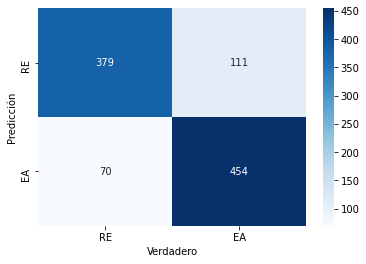

In [11]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

confm = confusion_matrix(array_Y,array_prediction)
print(confm)

columnas = ['RE','EA']
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)

print(df_cm)

grafica = sns.heatmap(df_cm, cmap='Blues', annot=True, fmt="d")


plt.ylabel('Valores verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel='Verdadero',ylabel='Predicción')
plt.show
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/confm_dropout05025025_256x256.png', dpi = 500)

[[0.37376726 0.10946746]
 [0.06903353 0.44773176]]
          RE        EA
RE  0.373767  0.109467
EA  0.069034  0.447732


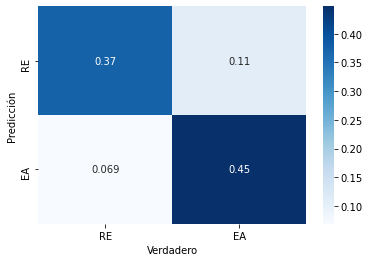

In [12]:
confm = confusion_matrix(array_Y,array_prediction)
confm = confm/1014
print(confm)

columnas = ['RE','EA']
df_cm = pd.DataFrame(confm, index=columnas, columns=columnas)

print(df_cm)

grafica = sns.heatmap(df_cm, cmap='Blues', annot=True)


plt.ylabel('Valores verdaderos')
plt.xlabel('Predicciones')
grafica.set(xlabel='Verdadero',ylabel='Predicción')
plt.show
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/percent_confm_dropout05025025_256x256.png', dpi = 500)

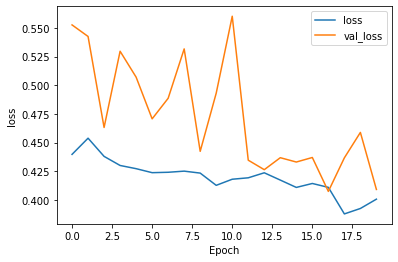

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(loc='upper right')
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/loss_dropout05025025_256x256.png', dpi = 500)

In [14]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.savefig('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/accuary_dropout05025025_256x256.png', dpi = 500)

KeyError: 'accuracy'

In [15]:
#Con el siguiente codigo guardo los arrays de la matriz de confusion, los valores de loss y val_loss

with open('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/dropout_05025025_256x256.npy', 'wb') as f:
    np.save(f, confm)
    np.save(f, history.history['loss'])
    np.save(f, history.history['val_loss'])
    
with open('/mnt/MD1200A/lconcha/videos/Modelos/DropOut_05_025_025_256x256/dropout_05025025_256x256.npy', 'rb') as f:
    a = np.load(f)
    b = np.load(f)
    c = np.load(f)
    
print(a, b,c)

[[0.37376726 0.10946746]
 [0.06903353 0.44773176]] [0.4397034  0.45382625 0.43795523 0.4300262  0.42723361 0.42374447
 0.42409554 0.42507881 0.4233757  0.41269436 0.41802055 0.41926774
 0.42363665 0.41728944 0.41087979 0.41431874 0.41092929 0.38776436
 0.39251122 0.40062854] [0.55264759 0.54256469 0.46318403 0.52967227 0.50707489 0.47070062
 0.48864755 0.53171825 0.44235879 0.49312264 0.56020826 0.43463224
 0.42635751 0.43680453 0.43302783 0.43699038 0.40740934 0.43668398
 0.45885295 0.40910432]
